In [ ]:
import tqdm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader, Dataset, Subset

from smallnet import LinearNet, Net, split_dataset

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install umap-learn

In [ ]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    N, total_accuracy, total_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        output = clf(images)
        loss = criterion(output, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        _, predicted = torch.max(output, 1)
        total_accuracy += (predicted == labels).sum().item()
        total_loss += loss.item()
        N += len(labels)
    return total_loss/len(loader), total_accuracy/N


def epoch_test(loader, clf, criterion):
    clf.eval()
    N, total_accuracy, total_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        output = clf(images)
        loss = criterion(output, labels)
        _, predicted = torch.max(output, 1)
        total_accuracy += (predicted == labels).sum().item()
        total_loss += loss.item()
        N += len(labels)
    return total_loss/len(loader), total_accuracy/N


def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50, PATH='/content/drive/MyDrive/ML/model.pth'):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' +
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

        '''torch.save({
            'epoch': epoch,
            'model_state_dict': clf.state_dict(),
            'optimizer_state_dict': opt.state_dict()
            }, PATH)'''

## CIFAR-10

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_transform = transforms.Compose([
    #transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=30),
    transforms.RandomCrop(32, padding=2),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

### Fine-tune Pretrained Model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EPOCHS = 40

clf = torchvision.models.resnet18(num_classes=10).to(device)
opt = optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
train(train_loader, test_loader, clf, criterion, opt, n_epochs=EPOCHS)

In [ ]:
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': clf.state_dict(),
            'optimizer_state_dict': opt.state_dict()
            }, PATH)

## MNIST

In [ ]:
BATCH_SIZE = 32
TRAIN_CLASS_SIZE = 512
NUM_WORKERS = 0

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.Grayscale(num_output_channels=3),  # Convert single-channel to three-channel
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2 * x - 1)  # Normalize MNIST data
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices, _ = split_dataset(train_dataset, num_train_per_class=TRAIN_CLASS_SIZE)

train_subset = Subset(train_dataset, train_indices)
test_subset =  test_dataset

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

### Fine-tune Pretrained Model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EPOCHS = 10

clf = torchvision.models.resnet18(num_classes=10).to(device)
opt = optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
train(train_loader, test_loader, clf, criterion, opt, n_epochs=EPOCHS)

 10%|█         | 1/10 [00:44<06:39, 44.37s/it]

[Epoch 1] train loss: 0.362; train acc: 0.89; test loss: 0.583; test acc: 0.83


 20%|██        | 2/10 [01:29<05:57, 44.65s/it]

[Epoch 2] train loss: 0.133; train acc: 0.96; test loss: 0.150; test acc: 0.95


 30%|███       | 3/10 [02:14<05:13, 44.74s/it]

[Epoch 3] train loss: 0.091; train acc: 0.97; test loss: 0.123; test acc: 0.96


 40%|████      | 4/10 [02:58<04:27, 44.54s/it]

[Epoch 4] train loss: 0.066; train acc: 0.98; test loss: 0.112; test acc: 0.96


 50%|█████     | 5/10 [03:42<03:42, 44.48s/it]

[Epoch 5] train loss: 0.052; train acc: 0.98; test loss: 0.067; test acc: 0.98


 60%|██████    | 6/10 [04:27<02:57, 44.44s/it]

[Epoch 6] train loss: 0.042; train acc: 0.99; test loss: 0.091; test acc: 0.97


 70%|███████   | 7/10 [05:11<02:12, 44.29s/it]

[Epoch 7] train loss: 0.040; train acc: 0.99; test loss: 0.153; test acc: 0.96


 80%|████████  | 8/10 [05:55<01:28, 44.32s/it]

[Epoch 8] train loss: 0.031; train acc: 0.99; test loss: 0.056; test acc: 0.98


 90%|█████████ | 9/10 [06:39<00:44, 44.35s/it]

[Epoch 9] train loss: 0.017; train acc: 0.99; test loss: 0.044; test acc: 0.99


100%|██████████| 10/10 [07:23<00:00, 44.37s/it]

[Epoch 10] train loss: 0.024; train acc: 0.99; test loss: 0.077; test acc: 0.98


### UMAP decomposition for MNIST, resnet-18

In [ ]:
X = test_dataset.data.cpu().detach().numpy().reshape(test_dataset.data.shape[0], -1)  # construct UMAP for test
y = test_dataset.targets.cpu().detach().numpy()

In [ ]:
def extract_features(model, dataloader):
    features = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
    return np.concatenate(features)


resnet = nn.Sequential(*list(clf.children())[:-1])  # Remove last layer
features = extract_features(resnet, test_loader)
features_flat = features.reshape(features.shape[0], -1)

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features_flat)

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

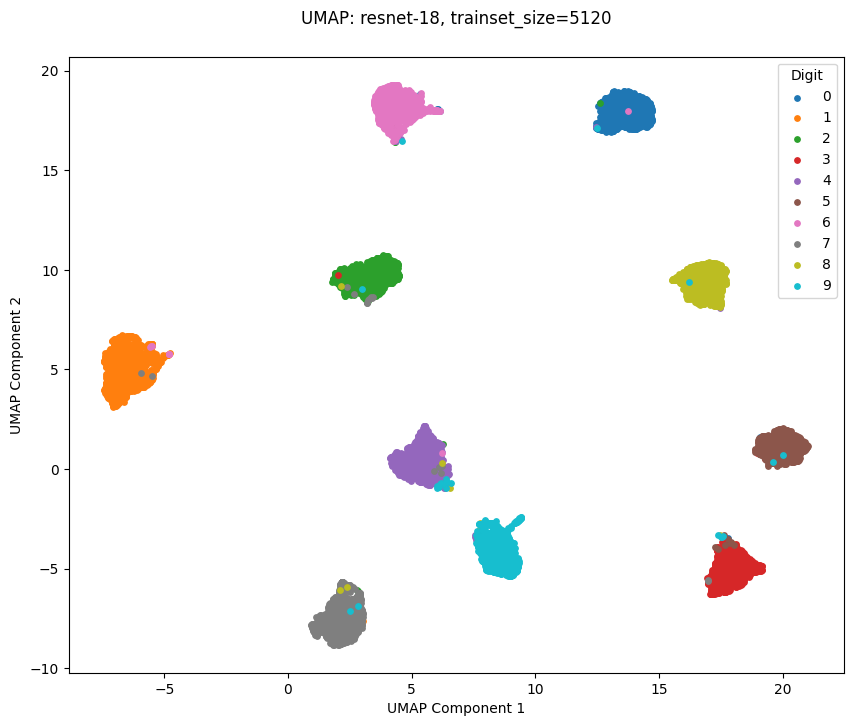

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], label=str(i), s=15)
plt.title('UMAP: resnet-18, trainset_size=5120', y=1.04)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Digit', loc='upper right')
plt.show()

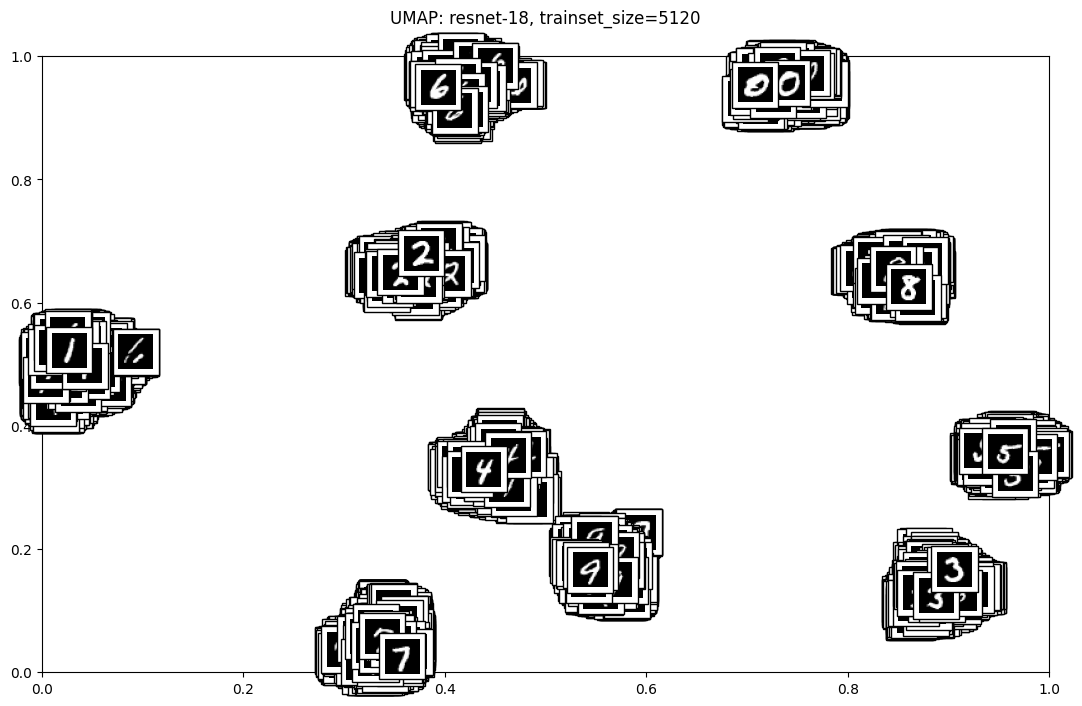

In [ ]:
def plot_embedding(X, y, images_small=None, title=None):
    """
    Nice plot on first two components of embedding with Offsets.
    """
    X = X[:, :2]
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(13,8))
    ax = plt.subplot(111)

    for i in range(X.shape[0] - 1):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.RdGy(y[i]),
                 fontdict={'weight': 'bold', 'size': 12})
        if images_small is not None:
            imagebox = OffsetImage(images_small[i], zoom=.9, cmap = 'gray')
            ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                xycoords='data')
            ax.add_artist(ab)

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-1:
                # don't show points that are too close
                continue
    if title is not None:
        plt.title(title, y=1.04)


data_pic = X.reshape((-1, 28, 28))
plot_embedding(X_umap, y, data_pic, f"UMAP: resnet-18, trainset_size={int(BATCH_SIZE * 10)}")

## Some loss history for trainings
don't look here...

### Batch_size = 512

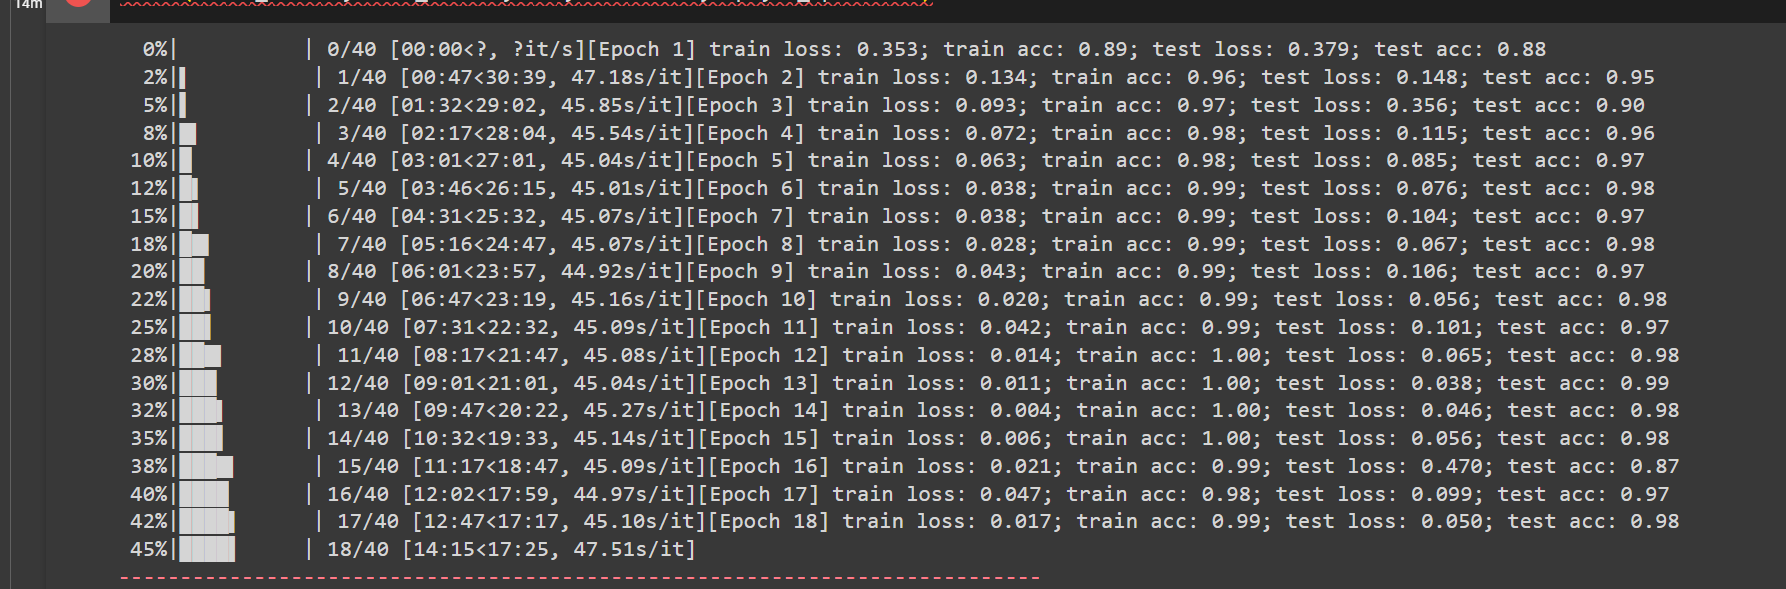

### Batch_size = 128

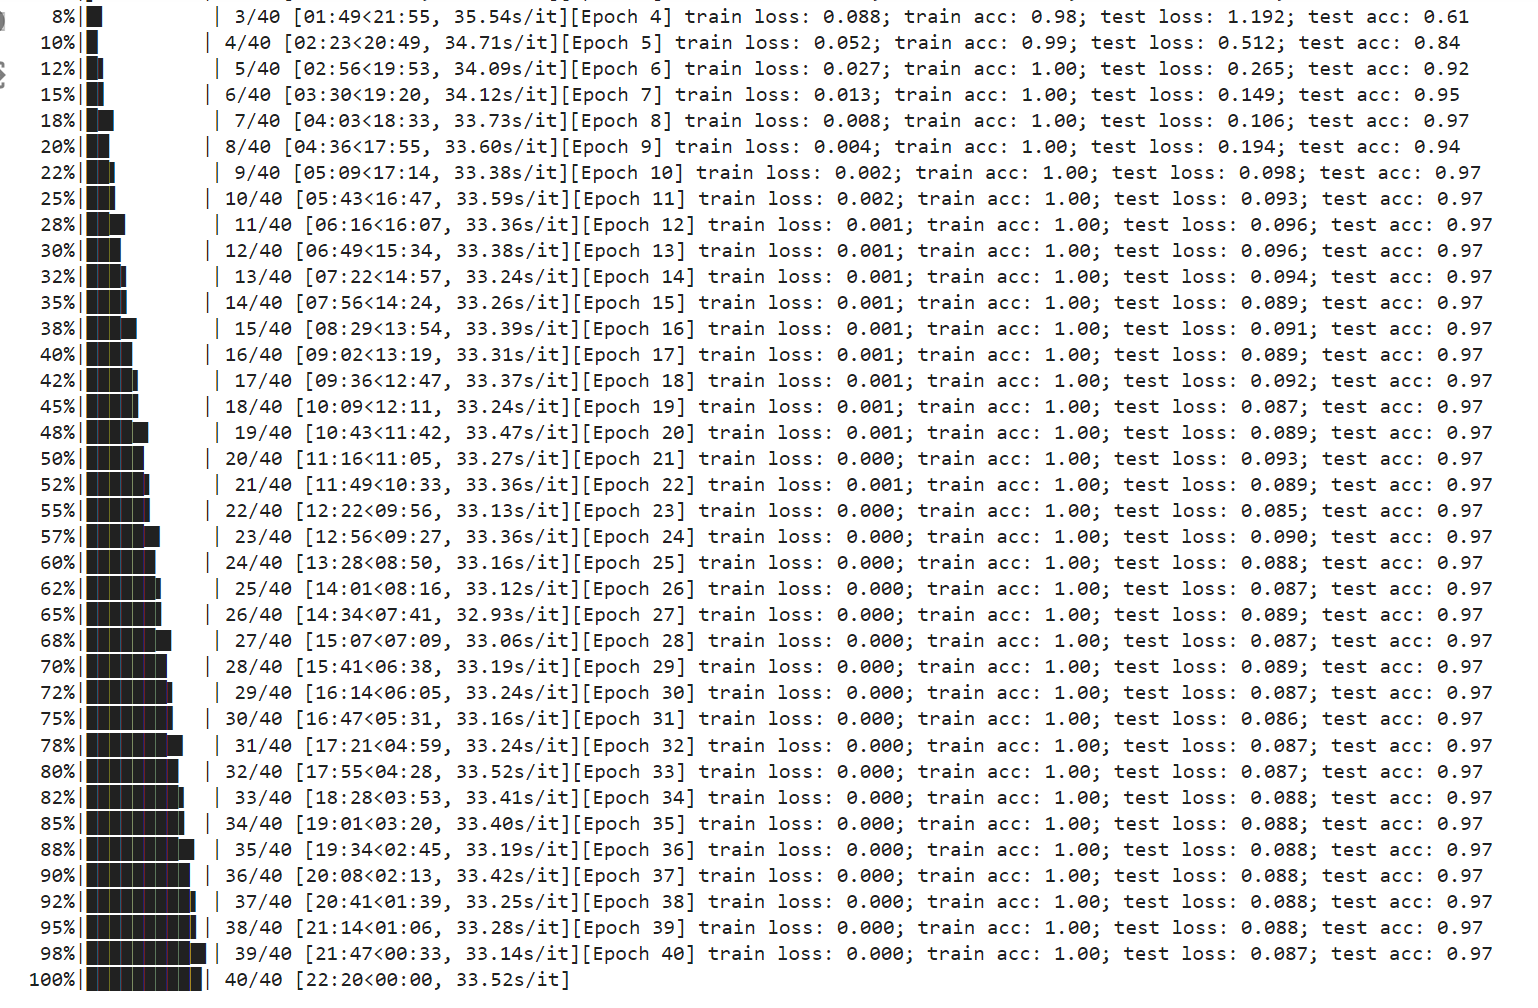

### Batch_size = 8

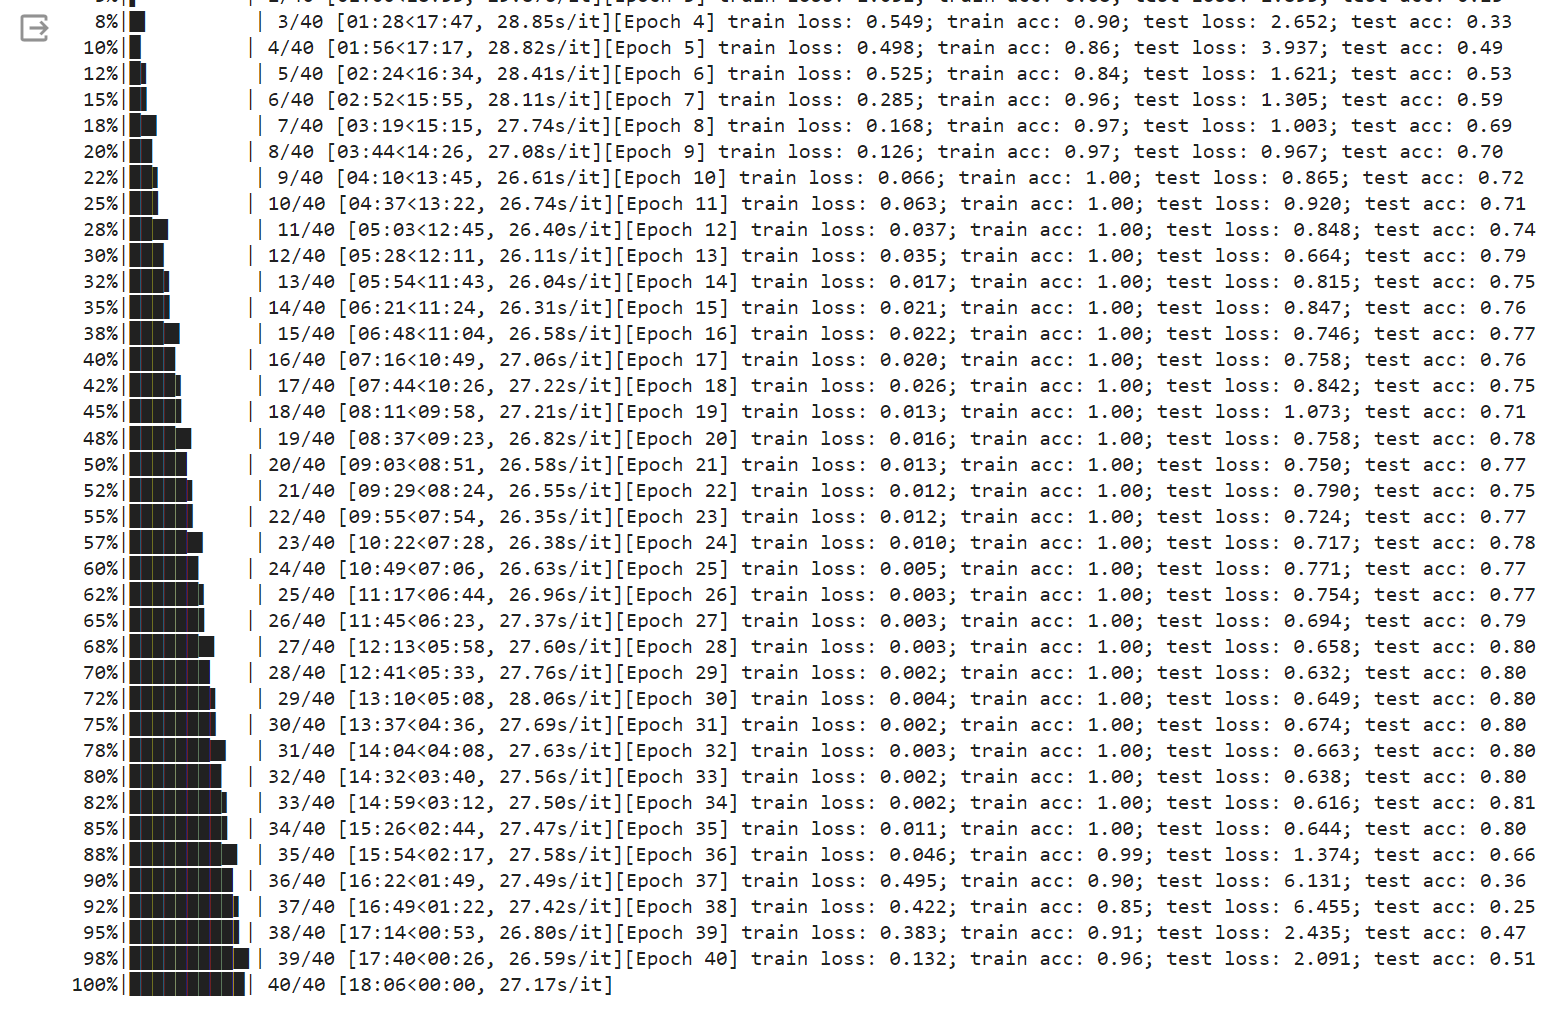